# How do Convolutions Work for a 1D Signal?

<p>Convolutions have become very popular in recent years, especially in the area of image processing. This is due to their ability to handle raw data from sensors. There is a lot of information available regarding neural nets involving 2D convolutions but not so much when it comes to 1D convolutions. It is my hope to contribute to that gap in this notebook/article.</p>



## How are 1D Convolutions Different From 2D Convolutions? 

- In a normal matrix operation, a map M is applied on input data x. This is shown in the image below.
    - On the left you see a big box of height m and width n, this represent the matrix Map, on the right you see the input data which has the same height as the map. When the map is applied on the input, it projects it according to the information encoded in the map

    <img src="normal_oper.png" wialign="center"/>


- The convolution operation is similar to a normal matrix operation in a sense that it is also a kind of projection of the input data onto a differnt representation. Here, instead of a matrix map, kernels are used to create the projection.
    - Essentially, the operation involves computation of dot products as the kernel (a sort of filter) moves across the data
    - On the left you see the kernles stacked on eachother (given in different colors), on the right you see the result of convolution.
        - There are 3 kernels and they are applied on the input **n**, resulting in 3 different matrices  
        <img src="kernel_conv.png" wialign="center"/>

    - The kernel can also be applied on a multi-channel data like in the case of a stereo input. This is shown in the image below.
        - Here the kernel will slide downwards (only in one direction, hence 1D convolution) resulting in convoluted data shown on the right
            - In this case, the convolution results in a scalar product. This is shown with mini-boxes on the right side of the image below
        <img src="1d_conv.png" wialign="center"/>


In [1]:
# Import the usual suspects
import torch
from torch import nn

import numpy as np

### Stereo Channel Input

- Consider a stereo input which has two 1D channels (Left and Right). The following convolutional architecture would be suitable to handle such input.
    - Input channels = 2
    - Output channels = 16
        - This means 16 kernels are applied to generate 16 outputs
    - Kernel size = 3

In [2]:
# 16 channels
# 2 channels
# 3 length

conv = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3)
print('Architecture\n\t',conv)

print('\nWeights\n\t', conv.weight.size())


print('\nBias\n\t',conv.bias.size())
# 1 bias per channel so 16

Architecture
	 Conv1d(2, 16, kernel_size=(3,), stride=(1,))

Weights
	 torch.Size([16, 2, 3])

Bias
	 torch.Size([16])


### Testing 1D Convolutional Layer

- The 1D CNN architecture is now able to process two channel sound system
- Note that whenever a signal is convolved, the length of the data will reduce by the kernel number minus one 
    - len(data) after convolution = len(data)_before - (k-1)
    - In this case, there are 64 samples for each channel so after convolution, there will be 62 samples (64 - (3 - 1) = 62)
    
- The data needs to be padded such that the data doesn't shrink too much
- Stride -> how much you move the kernel
- Batches -> how many signals you are using 

In [3]:
# Generate random data
# 1 signal, 2 channels, 64 samples
x = torch.randn(1, 2, 64)

print('Bias: ', conv.bias.size())
print('Output: ', conv(x).size())


Bias:  torch.Size([16])
Output:  torch.Size([1, 16, 62])


- The output above shows a reduction of 2 points in the input data x

### Gradients
- In order to train neural networks, we need to caculate the gradients and back propagate them in the network. This is a tedious process, luckily though pytorch will do this for us so that we can just focus on the more abstract work 
    - The automatic gradient tool of PyTorch in order to calculate and keep track of gradients
- PyTorch has an automatic funciton **grad_fn** that handles differentiation of tensors
- It works as follows

In [4]:
# Lets use a 2x2 tensor with gradient

x = torch.tensor([[1, 2], [3, 4]], requires_grad=True, dtype=torch.float32)
print(x)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


- When the argument **requires_grad** is set to **True**, PyTorch will automatically keep track of gradients involving the given variable
- Lets create another variable **y** and relate it with **x** 

In [5]:
# perform some operation
y = x - 2

print('Gradient function: ',y.grad_fn)
print()
print(y.grad_fn.next_functions[0][0])
print(y.grad_fn.next_functions[0][0].variable) # the original tensor

# Do another operation on y
z = y * y * 3
a = z.mean()

print(z)
print(a)

Gradient function:  <SubBackward0 object at 0x7f9a36bf9850>

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
tensor([[ 3.,  0.],
        [ 3., 12.]], grad_fn=<MulBackward0>)
tensor(4.5000, grad_fn=<MeanBackward0>)


#### Using torchviz to visualize operation done on **a**

- torchviz is a useful tool that we can use to visualize operations done on a given variable
- The visualization shows us the following
    - SubBackward0 -> x - 2
    - MulBackward0 -> y * y * 3
    - MeanBackward0 -> z.mean()

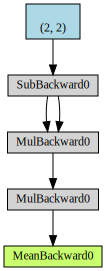

In [6]:
from torchviz import make_dot

make_dot(a)

#### Computing backpropagation.
- This computes gradients to be used for training neural nets with gradient descent

- The gradient is manually computed below:
    <img src="derivative.png" wialign="center"/>
    
    - PyTorch can seamlessly do this:

In [7]:
# compute gradients by using backward()
a.backward()
print(x)
print('\nGradient:')
print(x.grad)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

Gradient:
tensor([[-1.5000,  0.0000],
        [ 1.5000,  3.0000]])
